## Radar Plots
Radar plots are an excellent way to display a number of details about player performance across a number of categories.  It allows a lot to be provided in a small pacakge.  The only challenge is the comparison of areas or arcs of a circle.  This is something people tend to do poorly, and has often been critized by data proponents in the community when it comes to visualizations.  That said, they still have an application in certain situation, and player profiles is one of those cases.

This lesson goes step-by-step through the process of making player radars for a striker. Calculations of the metrics will be created directly from a count of actions in the Wyscout event data.
- Non-penalty goals
- Assists
- Key passes
- Smart passes
- Ariel duels won
- Ground attacking duels won

Adding tho these to the calculations conducted previously:
- non-penalty expected goals.
- passes ending in final third
- receptions in final third.

### Imports
Required imports for the analysis.

In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Load Data
This analysis will be leveraging the Wyscout data for the metrics creation.

In [2]:
#load data - store it in train dataframe
train = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    train = pd.DataFrame(data)

In [3]:
#potential data collection error handling, doesn't create a difference that is visible
train2 = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]
train2.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172


In [4]:
# train['positions'][0][0]['x']
train.head(2)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172


## Add xG Statistic
For the metrics expected goals is a key element to the overall view of striker performance, and is being added to the DataFrame. Two different models for xG will be used, one for headers and another for shots with leg. Then, the xG statistic is calculated. If there is interest is using non-penalty xG set the npxG value of the function to True. The function will then Calculate the cummulative xG for all players and return a dataframe groupped by playerId and this value.

This xG process uses the same method as in lesson 2 to caluclate xG for each position.

In [5]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    # A very basic xG model based on an updated shots dataframe
    shots = (df.loc[df["eventName"] == "Shot"].copy()
             .assign(X = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100),
                     Y = lambda df: df.positions.apply(lambda cell: cell[0]['y'] * 68/100),
                     C = lambda df: df.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100),
                     Distance = lambda df: np.sqrt(df["X"]**2 + df["C"]**2),
                     Angle = lambda df: np.where(np.arctan(7.32 * df["X"] / (df["X"]**2 + df["C"]**2 - (7.32/2)**2)) > 0,
                                      np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)), 
                                      np.arctan(7.32 * df["X"] /(df["X"]**2 + df["C"]**2 - (7.32/2)**2)) + np.pi),
                     Goal = lambda df: df.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
                    )
            )
    # Split shots into headers (id = 403) and non headers
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    
    # Create a model for both types of shot
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers,
                               family=sm.families.Binomial()).fit()
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers,
                               family=sm.families.Binomial()).fit()
    
    # Assigning xG to each, headers and non headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)

    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)

    # Account for penalties based on selection, Then groupby playerID
    if npxG == False:
        # find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        # assign 0.8
        penalties = penalties.assign(xG = 0.8)
        # concat all three(pens, heads and nonheads), group and sum only playerId and xG
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        #concat (headers and non headers), group and sum only playerId and xG
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
    #group by player and sum

    return xG_sum

In [6]:
#making function
npxg = calulatexG(train, npxG = True)
#investigate structure
npxg.head(3)

,playerId,npxG
0,8717,22.014180
1,120353,17.215819
2,11066,14.144484


## Calculating passes ending in final third and receptions in final third
These two (2) statistics capture how good a player is in receiving and passing th ball in the final third. These statistics add context to passes. It isn’t enough for a striker to be a good passer of the ball. He or she should be able to perform well in the final third.

To understand the information about receptions, the basic idea is that the player who made the next action was the receiver. The data is filtered for successful passes that ended in the final third obtaining the passer and the passes  receiver. Similar to the last step, sum the movement by player and merge these dataframes to return one. Note the use of an outer join to avoid forgeting a player who made no receptions in the final third, bud did make some passes.

In [7]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player.

    """
    df['nextPlayerId'] = df.playerId.shift(-1)
    passes = (df.loc[train["eventName"] == "Pass"].copy()
              .assign(x = lambda df: df.positions.apply(lambda cell: (cell[0]['x']) * 105/100),
                      y = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100),
                      end_x = lambda df: df.positions.apply(lambda cell: (cell[1]['x']) * 105/100),
                      end_y = lambda df: df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100))
             )

    # get accurate passes
    accurate_passes = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    
    # get passes into final third
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]

    # passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)

    # receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)

    # outer join not to lose values
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

In [8]:
final_third = FinalThird(train)
#investigate structure
final_third.head(3)

,playerId,final_third_passes,final_third_receptions
0,36.0,186.0,83.0
1,38.0,62.0,66.0
2,48.0,392.0,188.0


## Calculating air and ground duels won
Adding number of duels won, there is a need to differentiate between air and attacking ground duels - many of them will be dribbles. The deifinition of Wyscout duel can be found in the API. Both for air duels and attacking ground duels repeat the next steps - sum them by player and outer join the two dataframes.

In [9]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    # 703 is the id of a won duel
    won_air_duels = (df.query("subEventName == 'Air duel'")
                     .loc[lambda df: df.apply(lambda x:{'id':703} in x.tags, axis = 1)]
                    )

    # group and sum air duels
    wad_player =  (won_air_duels
                   .groupby(["playerId"])
                   .eventId.count()
                   .reset_index().rename(columns = {'eventId':'air_duels_won'})
                  )

    # find ground duels won
    won_ground_duels = (df.loc[df["subEventName"].isin(["Ground attacking duel"])]
                        .loc[lambda df: df.apply (lambda x:{'id':703} in x.tags, axis = 1)]
                       )

    wgd_player =  (won_ground_duels
                   .groupby(["playerId"])
                   .eventId.count()
                   .reset_index().rename(columns = {'eventId':'ground_duels_won'})
                  )

    # outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

In [10]:
duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0


## Calculating smart passes
Another statistic to add are accurate smart passes. Those are the passes that break the opponent's defensive line. The exact deifinition of Wyscout smart pass can be found in the API docs. Again in this case, sum smart passes by player.

In [11]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    # get accurate smart passes by subevent and tag for completion
    smart_passes_made = (df.query('subEventName == "Smart pass"')
                         .loc[lambda df: df.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
                        )

    # sum by player
    sp_player =  (smart_passes_made.groupby(["playerId"]).eventId.count().reset_index()
                  .rename(columns = {'eventId':'smart_passes'})
                 )

    return sp_player

In [12]:
smart_passes = smartPasses(train)
#investigate structure
smart_passes.head(3)

,playerId,smart_passes
0,36,1
1,38,1
2,48,3


## Calculating impact plays (G, A, KP)
The radar plots wouldn’t be completed without non-penalty goals, assists and key passes. To sum them, repeat steps previosuly described.

In [13]:
def GoalsAssistsKeyPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.

    """
    # get goals
    goals = df.query('subEventName == "Shot"').loc[lambda df: df.apply(lambda x:{'id':101} in x.tags, axis = 1)]
    
    # get assists
    assists = df.query('eventName == "Pass"').loc[lambda df: df.apply(lambda x:{'id':301} in x.tags, axis = 1)]
    
    # get key passes
    key_passes = df.query('eventName == "Pass"').loc[lambda df: df.apply(lambda x:{'id':302} in x.tags, axis = 1)]

    # goals by player
    g_player =  (goals
                 .groupby(["playerId"])
                 .eventId.count()
                 .reset_index().rename(columns = {'eventId':'goals'})
                )

    # assists by player
    a_player =  (assists
                 .groupby(["playerId"])
                 .eventId.count()
                 .reset_index().rename(columns = {'eventId':'assists'})
                )

    # key passes by player
    kp_player =  (key_passes
                  .groupby(["playerId"])
                  .eventId.count()
                  .reset_index().rename(columns = {'eventId':'key_passes'})
                 )

    data = (g_player
            .merge(a_player, how = "outer", on = ["playerId"])
            .merge(kp_player, how = "outer", on = ["playerId"])
           )
    
    return data

In [14]:
gakp = GoalsAssistsKeyPasses(train)
#investigate structure
gakp.head(3)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0


## Minutes played
All data on our plot will be per 90 minutes played. Therefore, the number of minutes played throughout the season will be needed to normalize the plots. To do so will require a prepared file that is based on an idea developed by students taking part in course in 2021. Files with miutes per game for players in top 5 leagues can be found here. After downloading data and saving it in the working directory, open and store the data in a dataframe. Then calculate the sum of miutes played in a season for each player.

In [15]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"footy_analytics", 'minutes_played_per_game_England.json')
# with open("test.json", encoding='utf-8') as data_file:                           
#     data = json.load(data_file)
with open(path, encoding = 'utf-8') as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

In [16]:
minutes.head()

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343
3,54,3348
4,56,266


## Summary table - Bringing it all together
To make the radar plots the data must first be prepared using the previously calculated statistics. Left join (too keep all the players) across the datasets. Also, left join minutes, because there are some players who were on the pitch but didn’t make an action. Then Nan observations are filled with zeros (if there was Nan scored goals it meant no scores). Finally filter out players who played less than or equal to 400 miutes.

In [17]:
players = train["playerId"].unique()

In [18]:
summary = (pd.DataFrame(players, columns = ["playerId"])
           .merge(npxg, how = "left", on = ["playerId"])
           .merge(final_third, how = "left", on = ["playerId"])
           .merge(duels, how = "left", on = ["playerId"])
           .merge(smart_passes, how = "left", on = ["playerId"])
           .merge(gakp, how = "left", on = ["playerId"])
          )

In [19]:
summary.head(2)

,playerId,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,25413,10.176593,296.0,465.0,129.0,24.0,9.0,12.0,4.0,18.0
1,370224,0.153351,61.0,50.0,8.0,27.0,1.0,NaN,NaN,NaN


In [20]:

summary = (minutes
           .merge(summary, how = "left", on = ["playerId"])
           .fillna(0)
           .loc[lambda df: df.minutesPlayed > 400]
          )

In [21]:
summary.head(2)

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.604683,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
2,48,3343,1.236777,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0


## Filtering positions
To create a plot with attacking actions, it is important to forcus on forwards (also, the player the plot is for iis a forward). Therefore, open the players dataset, filter for forwards and inner join it with the summary dataframe to keep only Premier League forwards who played more than 400 minutes.

In [22]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'footy_analytics',"data", 'players.json')
with open(path) as f:
    players = json.load(f)

In [23]:
pd.DataFrame(players).head(2)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423


In [24]:
forwards = (pd.DataFrame(players)
            .loc[lambda df:df.apply(lambda x: x.role["name"] == "Forward", axis = 1)]
            .rename(columns = {'wyId':'playerId'})
           )

In [25]:
summary = summary.merge(forwards[['playerId', 'shortName']], how = "inner", on = ["playerId"])

## Calculating/Normalizing statistics per 90
To adjust the data for different number of minutes played, calculate each statistic being plotted per 90 minutes played. Practically, that means multiply the statistics by 90 and divide by the total number of minutes played for the player in question.

In [26]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

In [27]:
summary_per_90.shortName.unique()

array(['W. Bony', '\\u00c1lvaro Morata', 'Jes\\u00e9 Rodr\\u00edguez',
       'Joselu', 'Deulofeu', 'Pedro', 'A. S\\u00e1nchez',
       'S. Rond\\u00f3n', 'T. Hemed', 'Philippe Coutinho', 'T. Walcott',
       'R. Lukaku', 'D. Sturridge', 'J. Hern\\u00e1ndez', 'W. Rooney',
       'D. Welbeck', 'A. Carroll', 'J. Defoe', 'S. Ag\\u00fcero',
       'S. Long', 'G. Murray', 'M. Antonio', 'H. Robson-Kanu', 'H. Kane',
       'P. Crouch', 'T. Deeney', 'C. Austin', 'J. Rodriguez', 'A. Barnes',
       'S. Vokes', 'C. Wood', 'S. Berahino', 'J. King', 'A. Gray',
       'R. Sterling', 'C. Wilson', 'D. Gayle', 'J. Vardy',
       'M. Arnautovi\\u0107', 'S. Okazaki', 'Son Heung-Min', 'M. Diouf',
       'E. Choupo-Moting', 'Roberto Firmino', 'E. Kachunga', 'C. Quaner',
       'S. Okaka', 'M. Gabbiadini', 'A. Lacazette', 'J. Ayew', 'A. Ayew',
       'E. Hazard', 'S. Man\\u00e9', 'P. Aubameyang', 'O. Giroud',
       'C. Tosun', 'C. Benteke', 'L. Depoitre', 'G. Carrillo',
       'J. Izquierdo', 'I. Slimani'

## Finding values for a player
For the tutorial, Mohammed Salah is the focus player. 
1. Find his shortName in the summary database. 
2. Filter in the dataframe with data per 90 his statistics. 
3. Store these statistics in a list and calculate the percentile for the value. 

Since the distribution of statistics may not be uniform on the interval [minimum value - maximum value], it is better to use percentiles to size the section of a radar.

In [28]:
#player to investigate - Mohammed Salah
#only his statistics
salah = summary_per_90.loc[summary_per_90["shortName"] == "Mohamed Salah"]

In [29]:
kane = summary_per_90.loc[lambda df:df.shortName == 'H. Kane']
kane.T

,23
shortName,H. Kane
npxG_per90,0.618955
final_third_passes_per90,7.591378
final_third_receptions_per90,12.567948
ground_duels_won_per90,5.370197
air_duels_won_per90,1.743205
smart_passes_per90,0.449859
goals_per90,0.759138
assists_per90,0.056232
key_passes_per90,0.253046


In [30]:
salah.T

,61
shortName,Mohamed Salah
npxG_per90,0.517337
final_third_passes_per90,12.681135
final_third_receptions_per90,18.631052
ground_duels_won_per90,5.979967
air_duels_won_per90,0.300501
smart_passes_per90,0.751252
goals_per90,0.931553
assists_per90,0.210351
key_passes_per90,0.330551


In [31]:
#select columns desired and set preferred order
per_90_columns = salah[['npxG_per90', "goals_per90", "assists_per90", "key_passes_per90", 
               "smart_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", 
               "ground_duels_won_per90", "air_duels_won_per90"]]
per_90_columns_k = kane[['npxG_per90', "goals_per90", "assists_per90", "key_passes_per90", 
               "smart_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", 
               "ground_duels_won_per90", "air_duels_won_per90"]]

In [32]:
# Create a list of the record in the dataframe, rounding to two significant digits
values = [round(salah[column].iloc[0],2) for column in per_90_columns]
values_k = [round(kane[column].iloc[0],2) for column in per_90_columns_k]
# Calculate a list of Percentiles for Salah for each statistic versus the league forwards
percentiles = [int(stats.percentileofscore(summary_per_90[column],salah[column].iloc[0])) 
               for column in per_90_columns]
percentiles_k = [int(stats.percentileofscore(summary_per_90[column],kane[column].iloc[0])) 
               for column in per_90_columns_k]

## Making radar charts
To plot radar charts, use mplsoccer's amazing tutorials. 
1. Take a list of names that we would like to to describe the statistics. 
2. Download fonts using mplsoccer FontManager to make our plot look nicer 
3. Declare a PyPizza object which would make a pizza-like radar plot, but in the mplsoccer library there are different options avaliable. 
4. Make a pizza plot with our data using make_pizza method to put data on the plot. 

Note, as mentioned before, the size of the pizza slice is based on the percentile to avoid scaling issues across metrics. Therefore, to put the statistic on the plot, put the percentile on it. Add a title and subtitle to finish out the plot.

In [33]:
# list of statistics names for the plot along with colors, text and font formating
names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", 
         "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", 
         "Offensive Ground Duels Won", "Air Duels Won"]
tottenham_colors = ["steelblue"] * 2 + ["skyblue"] * 5 + ["cornflowerblue"] * 2
liverpool_colors = ["crimson"] * 3 + ["red"] * 3 + ["tomato"] * 3
text_colors = ["white"]*9
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

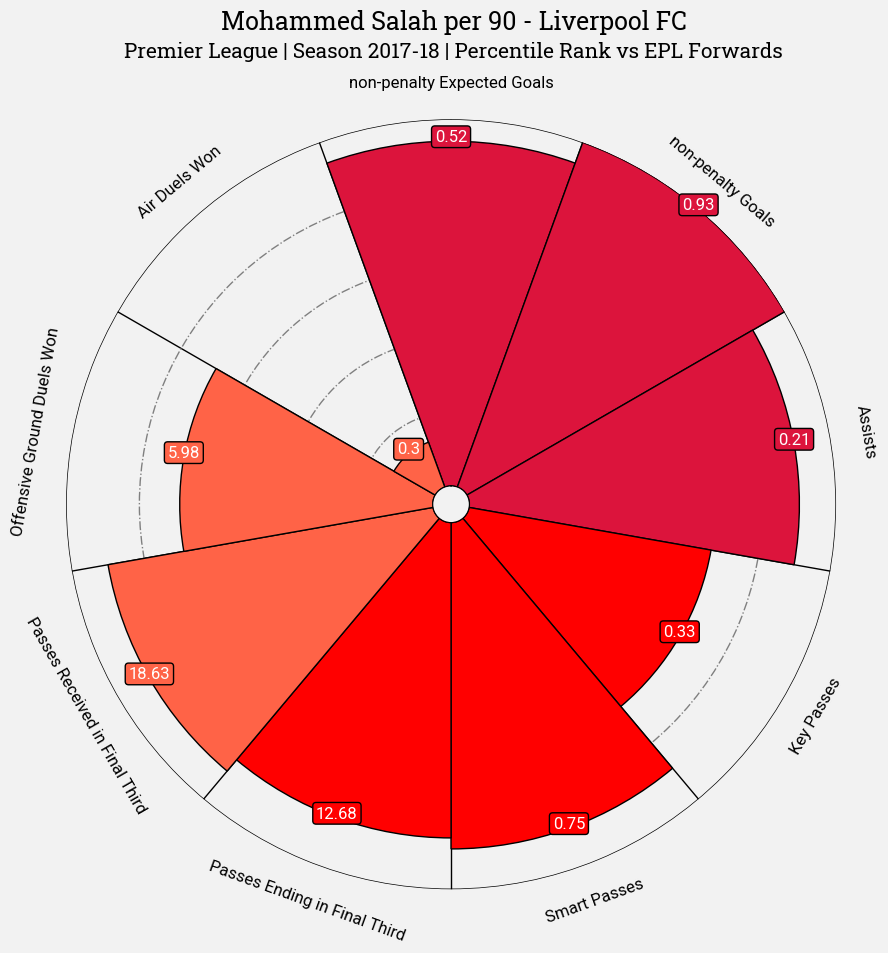

In [34]:
#PIZZA PLOT
baker = PyPizza(
    params=names,                   # previously created stats list
    min_range = None,
    max_range = None,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,                   # list of values
    figsize=(10, 10),              # adjust figsize according to your need
    param_location=110,
    slice_colors=liverpool_colors,     # previously created list
    value_colors = text_colors,    # previously created list
    value_bck_colors=liverpool_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="darkred", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                             # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                             # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="darkred",
            boxstyle="round,pad=0.2", lw=1
        )
    )                              # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 - Liverpool FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18 | Percentile Rank vs EPL Forwards",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

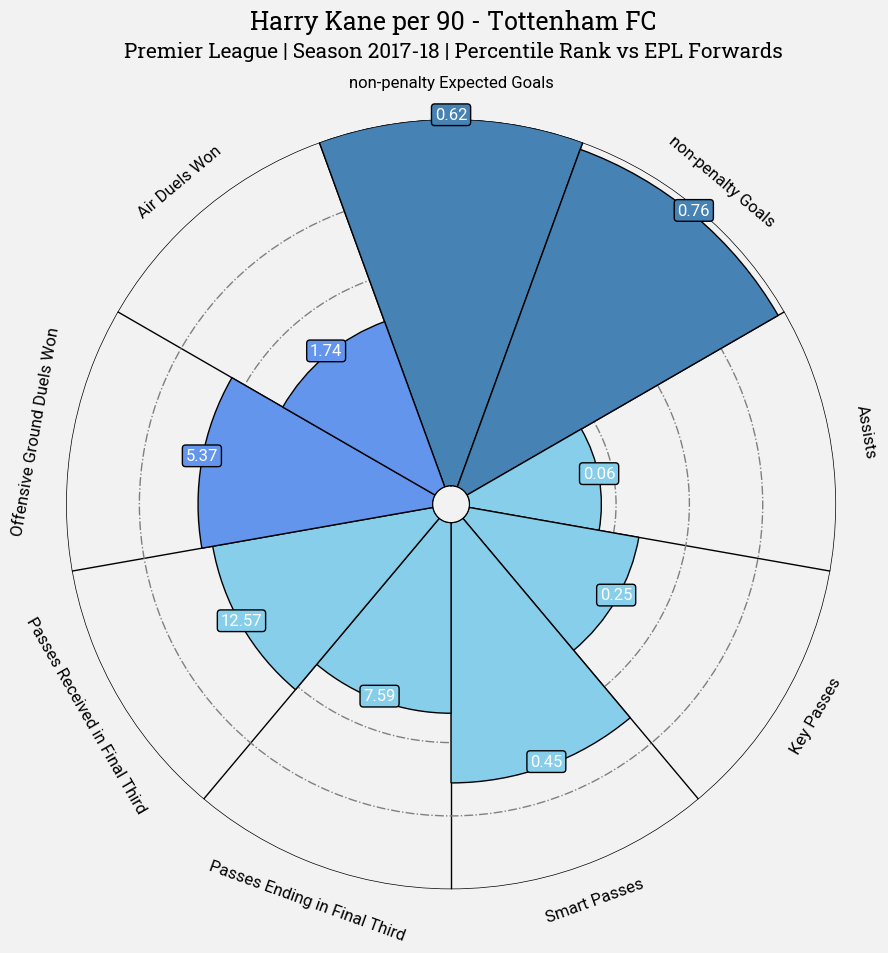

In [35]:
#PIZZA PLOT
baker = PyPizza(
    params=names,                   # previously created stats list
    min_range = None,
    max_range = None,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles_k,                   # list of values
    figsize=(10, 10),              # adjust figsize according to your need
    param_location=110,
    slice_colors=tottenham_colors,     # previously created list
    value_colors = text_colors,    # previously created list
    value_bck_colors=tottenham_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                             # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                             # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                              # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_k[i]))
# add title
fig.text(
    0.515, 0.97, "Harry Kane per 90 - Tottenham FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18 | Percentile Rank vs EPL Forwards",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)
plt.show()

## Calculating possession
The next step is adjusting the plot by the player’s team's ball possesion while they were on the pitch to normalize the total available opportunity. To do it, for each row in the dataframe with minutes per player per each game take all the events that were made in this game while the player was on the pitch. 
 
Also use duels, but don’t include lost air duels and lost ground defending duels. Why? Possesion is calculated as number of touches by team divided by the number all touches. If a player lost ground defending duel, that means that he could have been dribbled by, so he did not touch the ball. If they lost the air duel, they lost a header. Therefore, it is claimed  that those were mostly events where player may have not touched the ball (or if he did the team did not take control over it). 

1. Sum both team passes and duels and all passes and duels in this period. 
2. Store these values in a dictionary. 
3. Then, summing them for each player separately and calculating their ratio, get the possesion of the ball by player’s team while there were on the pitch. 
4. The last step is to merge it with the summary dataframe.

In [36]:
possesion_dict = {}
#for every row in the dataframe pull player id, team id, match id, minute in and minute out; create pass dict
for i, row in minutes_per_game.iterrows():
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    min_in, min_out = row["player_in_min"]*60, row["player_out_min"]*60
    
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    
    all_passes = (train
                  .loc[lambda df: df.matchId == match_id] #get the dataframe of events from the game
                  .assign(eventSec = lambda df:np.where(df.matchPeriod=="2H", #add to 2H the highest value of 1H
                                                      df.eventSec + df.query('matchPeriod == "1H"').eventSec.max(),
                                                      df.eventSec))
                  .query('eventSec > @min_in and eventSec <= @min_out') #take all events from this game and this period
                  .query('eventName.isin(["Pass","Duel"])') #take all passes and won duels as described
                 )
    
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = (all_passes
                      .query('subEventName.isin(["Air duel","Ground defending duel","Ground loose ball duel"])')
                      .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)])
        
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[lambda df:df.teamId == team_id]
    
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

In [37]:
#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

## Adjusting data for possession
Since the data is being adjusted for possession, divide the total statistics by the possesion while player was on the pitch during the entire season. To normalize the values per 90 minutes player repeat the multiplication by 90 and division by minutes played.

In [38]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:11]:
    summary_adjusted[column + "_adjusted_per90"] = (summary
                                                    .apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)
                                                   )

## Making the plot with adjusted data for Mohammed Salah
After calculating the values, repeat the steps by calculating percentiles and plotting radars from making the plot per 90. Note that this time we show the percentile rank on the plot.

In [39]:
salah_adjusted = (summary_adjusted.loc[summary_adjusted["shortName"] == "Mohamed Salah"]
                  .loc[:,['npxG_adjusted_per90', 
                           "goals_adjusted_per90", 
                           "assists_adjusted_per90", 
                           "key_passes_adjusted_per90", 
                           "smart_passes_adjusted_per90", 
                           "final_third_passes_adjusted_per90", 
                           "final_third_receptions_adjusted_per90", 
                           "ground_duels_won_adjusted_per90", 
                           "air_duels_won_adjusted_per90"]]
                 )

# values
values = [salah_adjusted[column].iloc[0] for column in salah_adjusted.columns[:]]

# percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], 
                                           salah_adjusted[column].iloc[0])) 
               for column in salah_adjusted.columns[:]]

In [40]:
kane_adjusted = (summary_adjusted.loc[summary_adjusted["shortName"] == "H. Kane"]
                  .loc[:,['npxG_adjusted_per90', 
                           "goals_adjusted_per90", 
                           "assists_adjusted_per90", 
                           "key_passes_adjusted_per90", 
                           "smart_passes_adjusted_per90", 
                           "final_third_passes_adjusted_per90", 
                           "final_third_receptions_adjusted_per90", 
                           "ground_duels_won_adjusted_per90", 
                           "air_duels_won_adjusted_per90"]]
                 )

# values
h_values = [kane_adjusted[column].iloc[0] for column in kane_adjusted.columns[:]]

# percentiles
h_percentiles = [int(stats.percentileofscore(summary_adjusted[column], 
                                           kane_adjusted[column].iloc[0])) 
               for column in kane_adjusted.columns[:]]

In [41]:
names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

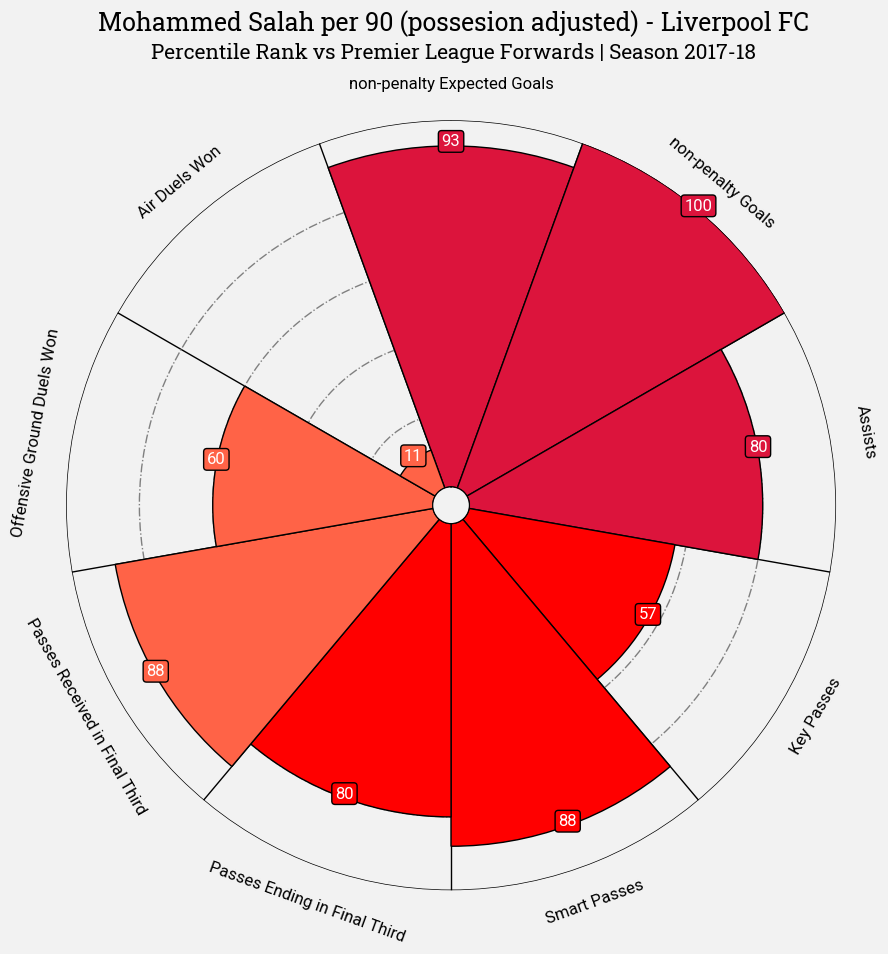

In [42]:
baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=liverpool_colors,
    value_colors = text_colors,
    value_bck_colors=liverpool_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="darkred", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="darkred",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 (possesion adjusted) - Liverpool FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.show()

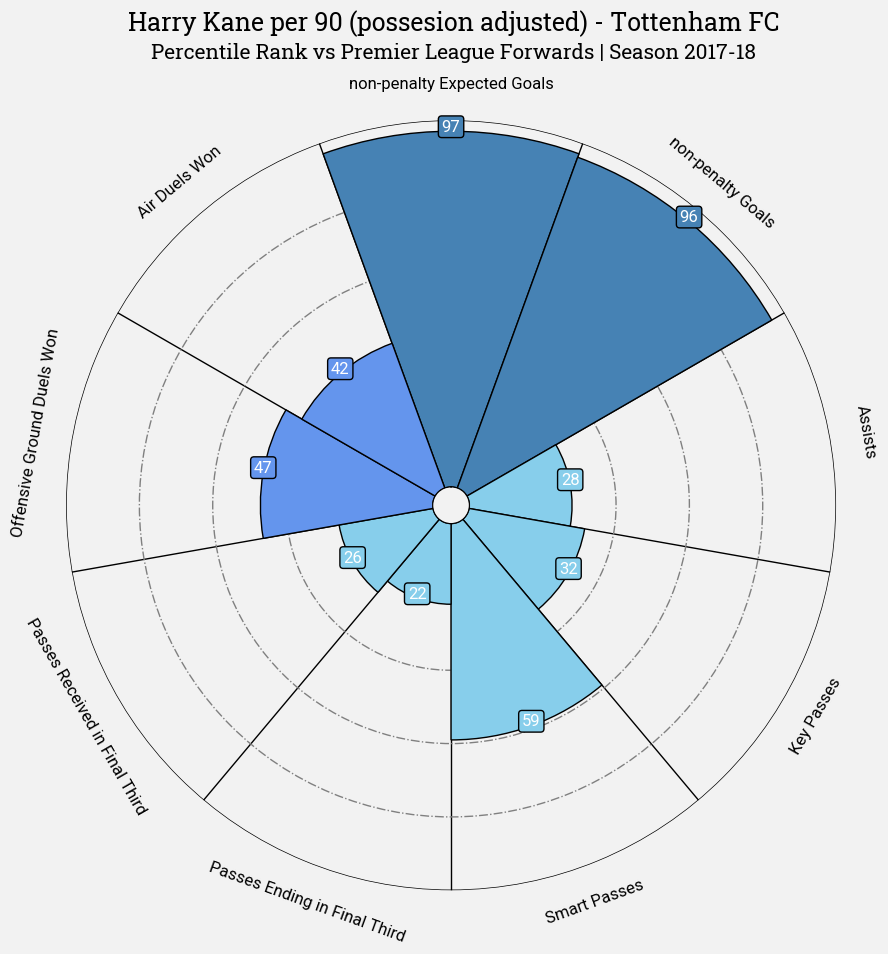

In [43]:
baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    h_percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=tottenham_colors,
    value_colors = text_colors,
    value_bck_colors=tottenham_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Harry Kane per 90 (possesion adjusted) - Tottenham FC", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.show()